In [ ]:
'''Student Name: Jiajun Yang
  Student ID: 1010128862
  Instructor Name: Prof. Shion Guha
  Course Code: INF2178
  Course Name: Experimental Design for Data Science
  Faculty: Faculty of Information
'''

'Student Name: Jiajun Yang\n  Student ID: 1010128862\n  Instructor Name: Prof. Shion Guha\n  Course Code: INF2178\n  Course Name: Experimental Design for Data Science\n  Faculty: Faculty of Information\n'

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install pingouin
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from scipy.stats import shapiro, levene

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/2178/INF2178_A4_data.csv')
data.head()

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [ ]:
summary_statistics = data.describe()
print(summary_statistics)

       Unnamed: 0       Visit     MR Delay         Age        EDUC  \
count  294.000000  294.000000   294.000000  294.000000  294.000000   
mean   190.421769    1.489796   349.785714   76.411565   14.561224   
std    106.686740    0.500748   400.741520    7.607074    2.884818   
min      0.000000    1.000000     0.000000   60.000000    6.000000   
25%     99.000000    1.000000     0.000000   71.000000   12.000000   
50%    195.500000    1.000000     0.000000   76.000000   14.500000   
75%    282.750000    2.000000   671.500000   81.000000   16.000000   
max    371.000000    2.000000  1707.000000   98.000000   23.000000   

              SES        MMSE         CDR         eTIV        nWBV         ASF  
count  279.000000  293.000000  294.000000   294.000000  294.000000  294.000000  
mean     2.491039   27.259386    0.301020  1478.853741    0.731381    1.203109  
std      1.128008    3.413454    0.381347   176.559755    0.037373    0.139365  
min      1.000000   15.000000    0.000000  11

In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

Unnamed: 0     0
Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           15
MMSE           1
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64


In [ ]:
# Retaining only the necessary columns
data = data[['Subject ID', 'MRI ID', 'Group', 'Visit', 'eTIV', 'Age','nWBV']]

# Displaying the first few rows to confirm the dataset now contains only the required columns
data.head()

,Subject ID,MRI ID,Group,Visit,eTIV,Age,nWBV
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,1987,87,0.696
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,2004,88,0.681
2,OAS2_0002,OAS2_0002_MR1,Demented,1,1678,75,0.736
3,OAS2_0002,OAS2_0002_MR2,Demented,2,1738,76,0.713
4,OAS2_0004,OAS2_0004_MR1,Nondemented,1,1215,88,0.710


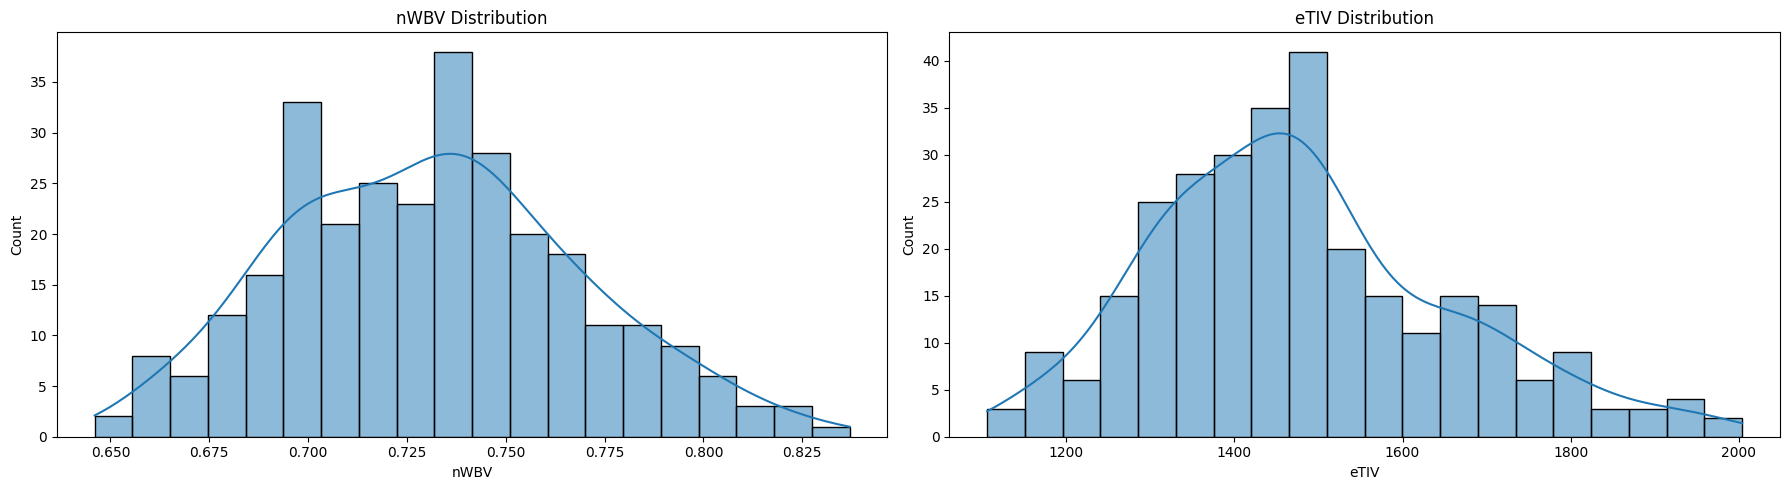

In [ ]:
# Plotting distributions for key variables
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# nWBV Distribution
sns.histplot(data['nWBV'], bins=20, kde=True, ax=axs[0])
axs[0].set_title('nWBV Distribution')

# eTIV Distribution
sns.histplot(data['eTIV'], bins=20, kde=True, ax=axs[1])
axs[1].set_title('eTIV Distribution')

plt.tight_layout()
plt.show()

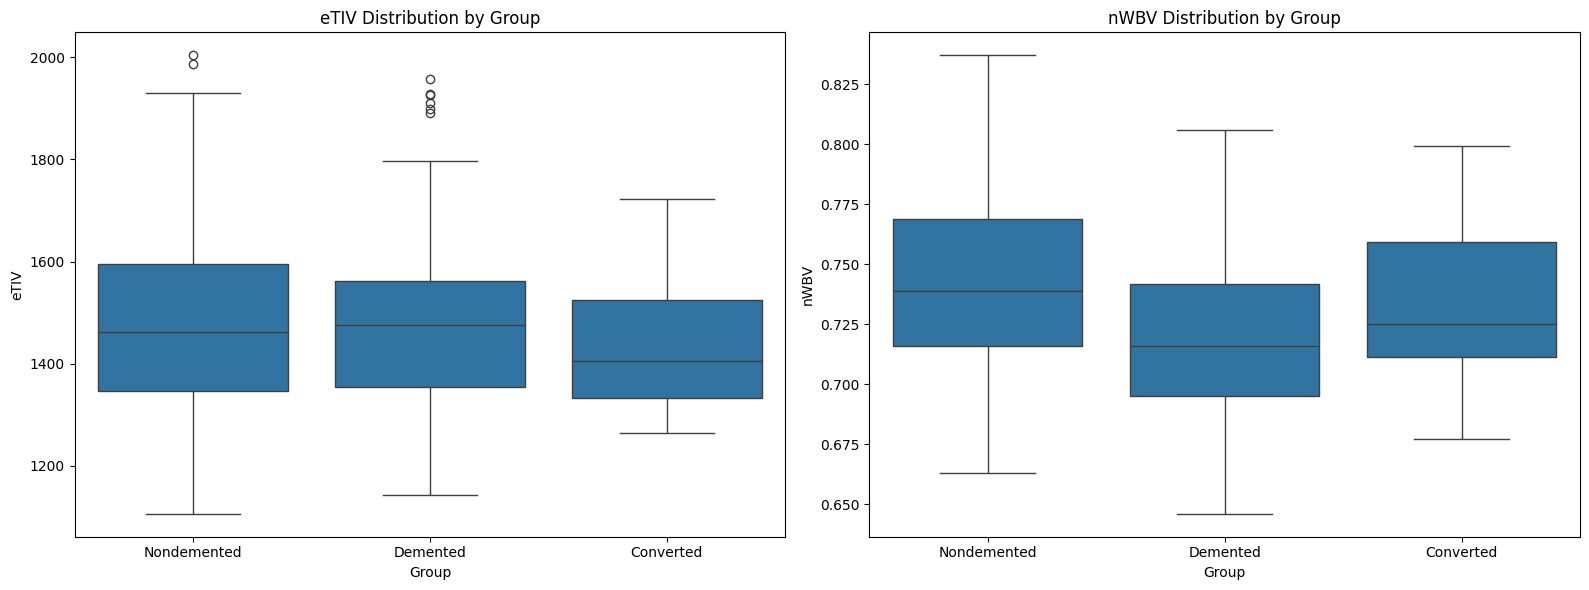

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting Age Distribution by Group on the first subplot
sns.boxplot(x='Group', y='eTIV', data=data, ax=axes[0])
axes[0].set_title('eTIV Distribution by Group')

# Plotting nWBV Distribution by Group on the second subplot
sns.boxplot(x='Group', y='nWBV', data=data, ax=axes[1])
axes[1].set_title('nWBV Distribution by Group')

plt.tight_layout()
plt.show()

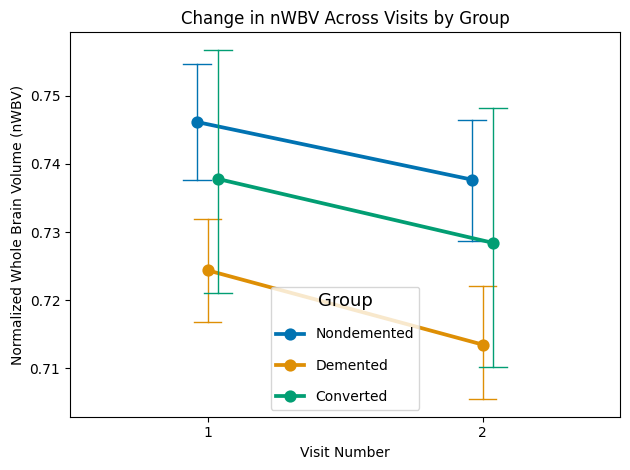

In [ ]:
sns.pointplot(data=data, x='Visit', y='nWBV', hue='Group', dodge=True,
              capsize=.1, err_kws={'linewidth': 1}, palette='colorblind')

plt.title('Change in nWBV Across Visits by Group')
plt.xlabel('Visit Number')
plt.ylabel('Normalized Whole Brain Volume (nWBV)')
plt.legend(title='Group', title_fontsize='13', labelspacing=1.25)

plt.tight_layout()
plt.show()

In [ ]:
# Mixed ANOVA Model for brain structure changes (nWBV)
aov_nWBV = pg.mixed_anova(dv='nWBV', within='Visit', between='Group', subject='Subject ID', data=data)
pg.print_table(aov_nWBV)

post_hocs_Group = pg.pairwise_ttests(dv='nWBV', within='Visit', subject='Subject ID', padjust='fdr_bh', data=data)
pg.print_table(post_hocs_Group)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
Group        0.034      2    141  0.017   6.712    0.002  0.087  nan
Visit        0.007      1    141  0.007  94.251    0.000  0.401    1.000
Interaction  0.000      2    141  0.000   1.534    0.219  0.021  nan


POST HOC TESTS

Contrast      A    B  Paired    Parametric        T      dof  alternative      p-unc                 BF10    hedges
----------  ---  ---  --------  ------------  -----  -------  -------------  -------  -------------------  --------
Visit         1    2  True      True          9.672  143.000  two-sided        0.000  225800000000000.000     0.255



/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [ ]:
lme = smf.mixedlm('nWBV ~ C(Visit) + C(Group)', data=data, groups=data['Subject ID']).fit()

# Calculate residuals
residuals = lme.resid

# Check for normality using Shapiro-Wilk test
stat, p = shapiro(residuals)
print('Normality assumption p-value:', p)

# Homogeneity of variances using Levene's test
stat, p = levene(data['nWBV'][data['Visit'] == 1], data['nWBV'][data['Visit'] == 2])
print('Homogeneity of variances p-value:', p)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


0.9620574712753296 5.904656745769898e-07
Homogeneity of variances p-value: 0.47812089267373725


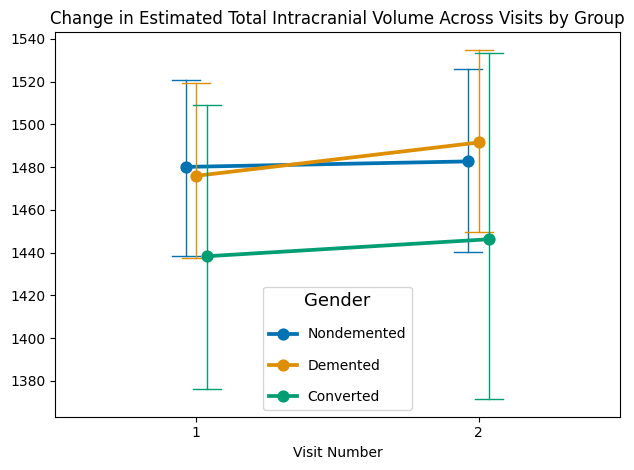

In [ ]:
sns.pointplot(data=data, x='Visit', y='eTIV', hue='Group', dodge=True,
              capsize=.1, err_kws={'linewidth': 1}, palette='colorblind')

plt.title('Change in Estimated Total Intracranial Volume Across Visits by Group')
plt.xlabel('Visit Number')
plt.ylabel('')
plt.legend(title='Gender', title_fontsize='13', labelspacing=1.25)

plt.tight_layout()
plt.show()

In [ ]:
aov = pg.mixed_anova(dv='eTIV', within='Visit', between='Group', subject='Subject ID', data=data)
pg.print_table(aov)

post_hocs_within = pg.pairwise_ttests(dv='eTIV', within='Visit', between='Group', subject='Subject ID', data=data, padjust='bonf')
pg.print_table(post_hocs_within)



ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
Group        37424.708      2    141  18712.354  0.297    0.743  0.004  nan
Visit         5573.920      1    141   5573.920  9.225    0.003  0.061    1.000
Interaction   1004.783      2    141    502.392  0.831    0.438  0.012  nan


POST HOC TESTS

Contrast       Visit    A          B            Paired    Parametric         T      dof  alternative      p-unc    p-corr  p-adjust      BF10    hedges
-------------  -------  ---------  -----------  --------  ------------  ------  -------  -------------  -------  --------  ----------  ------  --------
Visit          -        1          2            True      True          -3.041  143.000  two-sided        0.003   nan      nan          7.532    -0.049
Group          -        Converted  Demented     False     True          -0.897   17.630  two-sided        0.382     1.

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [ ]:
lme = smf.mixedlm('eTIV ~ C(Visit) + C(Group)', data=data, groups=data['Subject ID']).fit()

# Calculate residuals
residuals = lme.resid

# Check for normality using Shapiro-Wilk test
stat, p = shapiro(residuals)
print('Normality assumption p-value:', p)

# Homogeneity of variances using Levene's test
stat, p = levene(data['eTIV'][data['Visit'] == 1], data['eTIV'][data['Visit'] == 2])
print('Homogeneity of variances p-value:', p)

Normality assumption p-value: 4.252007610795567e-23
Homogeneity of variances p-value: 0.6905831498470318


Power: 45.451


<Figure size 640x480 with 0 Axes>

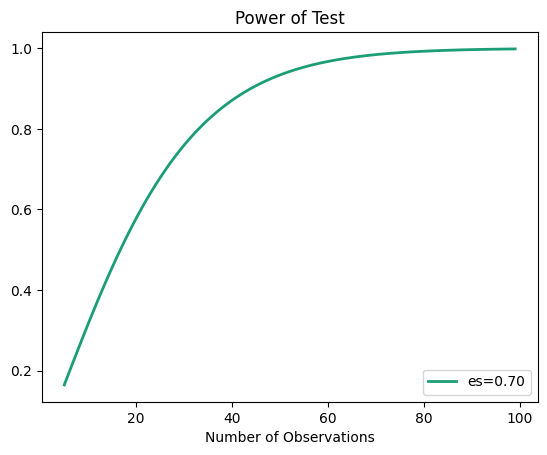

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestPower
from statsmodels.stats.power import TTestIndPower

power = TTestIndPower()
n_test = power.solve_power(effect_size = 0.7,
						power = 0.91, alpha = 0.05)
print('Power: {:.3f}'.format(n_test))

# Plot power curves
fig = plt.figure()
effect_sizes = np.array([0.7])
sample_sizes = np.array(range(5, 100))

# plot power curves
obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes,
			effect_size=effect_sizes)

plt.show()